In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:
n_variate = 1

In [3]:

#Load dataset
def load_dataset(path=r'dataset_test_v3.csv'):
  return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [5]:
def prepare_data(df):
  df_aux = df.drop(columns=['nr_ruas_afetadas', 'comprimento_fila_metros', 'demora_fila_segundos'], inplace=False)
  df_aux["data"] = pd.to_datetime(df_aux["data"])
  df_aux = df_aux.sort_values('data')
  df_aux = df_aux.set_index('data')
  return df_aux

In [6]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    #df[['cases']] = scaler.fit_transform(df[['cases']])
    # df[['nr_ruas_afetadas']] = scaler.fit_transform(df[['nr_ruas_afetadas']])
    df[['Nr_acidentes']] = scaler.fit_transform(df[['Nr_acidentes']])
    # df[['comprimento_fila_metros']] = scaler.fit_transform(df[['comprimento_fila_metros']])
    # df[['demora_fila_segundos']] = scaler.fit_transform(df[['demora_fila_segundos']])

    return scaler

In [7]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  mae=history.history['mae']
  val_mae=history.history['val_mae']
  rmse=history.history['rmse']
  val_rmse=history.history['val_rmse']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  # plt.plot(epochs_range,mae,label='Training MAE')
  # plt.plot(epochs_range,val_mae,label='Validation MAE')
  # plt.plot(epochs_range,rmse,label='Training RMSE')
  # plt.plot(epochs_range,val_rmse,label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [8]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [9]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [10]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [11]:
# 1 LSTM, 1 LSTM, 1 Densa, 1 Dropout, 1 Densa
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
  #Add a new layer
  model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
    #
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(n_variate, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'accidents_model.png', show_shapes=True)
  return model

In [12]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [13]:
#Main Execution
#the dataframes
df_raw = load_dataset()
df_data = prepare_data(df_raw)
df = df_data.copy()

scaler = data_normalization(df) #scaling data to [-1, 1]

In [14]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    #preparar novo input para fazer previsão para o dia seguinte
    inp= np.append(inp[0],[[yhat[0][0]]],axis=0) #adiciona previsão recente ao input
    inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
  return forecasts



In [15]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(14,6))
  plt.plot(range(len(data)), data['Nr_acidentes'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Nr de Acidentes em Braga')
  plt.ylabel('Value')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

# Tunning

In [16]:
'''tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 100, 'cv_splits': 10, 'epochs' : 10,  'batch_size' : 4 },
                2: {'timesteps' : 7, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 4 },
                3: {'timesteps' : 7, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 4 },

                #
                4: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits': 10, 'epochs' : 10,  'batch_size' : 2 },
                5: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 2 },
                6: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 2 }#,
                #
                #7: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits': 5, 'epochs' : 10,  'batch_size' : 1 },
                #8: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 50,  'batch_size' : 1 },
                #9: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 100,  'batch_size' : 1 }

                }'''

tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                2: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                3: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                #
                4: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                5: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                6: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                #
                7: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                8: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                9: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

}

# record da history de cada modelo
record = {}

Epoch 1/10
16/16 [==============================] - 5s 89ms/step - loss: 0.2947 - mae: 0.2567 - rmse: 0.2947 - val_loss: 0.3352 - val_mae: 0.2936 - val_rmse: 0.3133
Epoch 2/10
16/16 [==============================] - 0s 12ms/step - loss: 0.2561 - mae: 0.2080 - rmse: 0.2561 - val_loss: 0.4256 - val_mae: 0.3812 - val_rmse: 0.4030
Epoch 3/10
16/16 [==============================] - 0s 12ms/step - loss: 0.2454 - mae: 0.2022 - rmse: 0.2455 - val_loss: 0.4163 - val_mae: 0.3712 - val_rmse: 0.3943
Epoch 4/10
16/16 [==============================] - 0s 13ms/step - loss: 0.2345 - mae: 0.1985 - rmse: 0.2346 - val_loss: 0.4390 - val_mae: 0.3981 - val_rmse: 0.4175
Epoch 5/10
16/16 [==============================] - 0s 11ms/step - loss: 0.2349 - mae: 0.1940 - rmse: 0.2350 - val_loss: 0.4259 - val_mae: 0.3838 - val_rmse: 0.4046

Epoch 00005: val_loss improved from inf to 0.42587, saving model to my_model_5_0.426.h5
Epoch 6/10
16/16 [==============================] - 0s 12ms/step - loss: 0.2450 - mae:

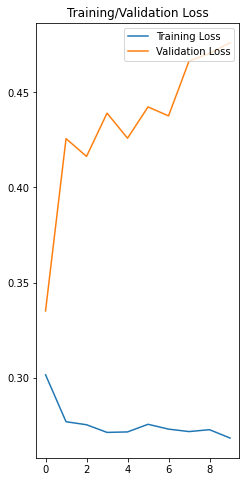

Epoch 1/10
31/31 [==============================] - 2s 10ms/step - loss: 0.3484 - mae: 0.3033 - rmse: 0.3484 - val_loss: 0.2374 - val_mae: 0.2034 - val_rmse: 0.2365
Epoch 2/10
31/31 [==============================] - 0s 8ms/step - loss: 0.3356 - mae: 0.2856 - rmse: 0.3356 - val_loss: 0.2396 - val_mae: 0.2035 - val_rmse: 0.2334
Epoch 3/10
31/31 [==============================] - 0s 8ms/step - loss: 0.3223 - mae: 0.2772 - rmse: 0.3223 - val_loss: 0.2458 - val_mae: 0.2085 - val_rmse: 0.2407
Epoch 4/10
31/31 [==============================] - 0s 8ms/step - loss: 0.3181 - mae: 0.2731 - rmse: 0.3181 - val_loss: 0.2471 - val_mae: 0.2101 - val_rmse: 0.2408
Epoch 5/10
31/31 [==============================] - 0s 9ms/step - loss: 0.3133 - mae: 0.2686 - rmse: 0.3133 - val_loss: 0.2460 - val_mae: 0.2087 - val_rmse: 0.2426

Epoch 00005: val_loss improved from 0.42587 to 0.24602, saving model to my_model_5_0.246.h5
Epoch 6/10
31/31 [==============================] - 0s 8ms/step - loss: 0.3139 - mae: 

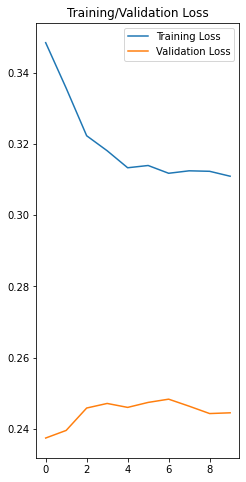

Epoch 1/10
47/47 [==============================] - 1s 26ms/step - loss: 0.2964 - mae: 0.2537 - rmse: 0.2991 - val_loss: 0.5053 - val_mae: 0.4626 - val_rmse: 0.5053
Epoch 2/10
47/47 [==============================] - 0s 10ms/step - loss: 0.2976 - mae: 0.2546 - rmse: 0.3005 - val_loss: 0.4678 - val_mae: 0.4332 - val_rmse: 0.4678
Epoch 3/10
47/47 [==============================] - 0s 9ms/step - loss: 0.3052 - mae: 0.2608 - rmse: 0.3079 - val_loss: 0.4438 - val_mae: 0.4080 - val_rmse: 0.4438
Epoch 4/10
47/47 [==============================] - 0s 10ms/step - loss: 0.2944 - mae: 0.2532 - rmse: 0.2974 - val_loss: 0.4600 - val_mae: 0.4247 - val_rmse: 0.4600
Epoch 5/10
47/47 [==============================] - 0s 10ms/step - loss: 0.2918 - mae: 0.2501 - rmse: 0.2948 - val_loss: 0.4557 - val_mae: 0.4185 - val_rmse: 0.4557

Epoch 00005: val_loss did not improve from 0.24450
Epoch 6/10
47/47 [==============================] - 0s 10ms/step - loss: 0.2900 - mae: 0.2457 - rmse: 0.2930 - val_loss: 0.4

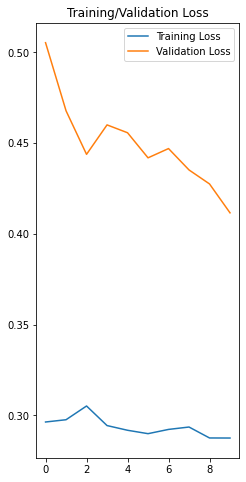

[array([[180.655]], dtype=float32), array([[295.00793]], dtype=float32), array([[294.15646]], dtype=float32), array([[170.54489]], dtype=float32), array([[231.12299]], dtype=float32), array([[306.60074]], dtype=float32), array([[175.71074]], dtype=float32), array([[241.40639]], dtype=float32), array([[275.82968]], dtype=float32), array([[257.53104]], dtype=float32), array([[224.17863]], dtype=float32), array([[255.7821]], dtype=float32), array([[264.20175]], dtype=float32), array([[228.20987]], dtype=float32), array([[260.789]], dtype=float32)]
[180.655, 295.00793, 294.15646, 170.54489, 231.12299, 306.60074, 175.71074, 241.40639, 275.82968, 257.53104, 224.17863, 255.7821, 264.20175, 228.20987, 260.789]


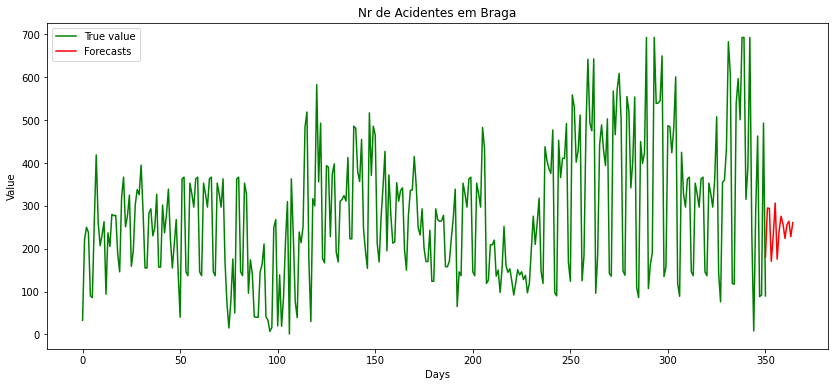

Epoch 1/50
16/16 [==============================] - 4s 67ms/step - loss: 0.2939 - mae: 0.2575 - rmse: 0.2940 - val_loss: 0.3269 - val_mae: 0.2872 - val_rmse: 0.3041
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.2578 - mae: 0.2092 - rmse: 0.2579 - val_loss: 0.4369 - val_mae: 0.3944 - val_rmse: 0.4134
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.2390 - mae: 0.1933 - rmse: 0.2391 - val_loss: 0.4064 - val_mae: 0.3595 - val_rmse: 0.3834
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.2370 - mae: 0.1972 - rmse: 0.2371 - val_loss: 0.4297 - val_mae: 0.3875 - val_rmse: 0.4072
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 0.2367 - mae: 0.1929 - rmse: 0.2368 - val_loss: 0.4255 - val_mae: 0.3833 - val_rmse: 0.4035

Epoch 00005: val_loss improved from inf to 0.42552, saving model to my_model_5_0.426.h5
Epoch 6/50
16/16 [==============================] - 0s 14ms/step - loss: 0.2389 - mae:

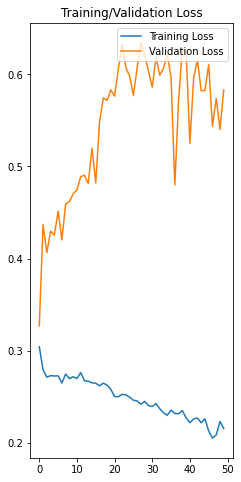

Epoch 1/50
31/31 [==============================] - 2s 11ms/step - loss: 0.3551 - mae: 0.3106 - rmse: 0.3551 - val_loss: 0.2101 - val_mae: 0.1814 - val_rmse: 0.2134
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.3030 - mae: 0.2567 - rmse: 0.3030 - val_loss: 0.2379 - val_mae: 0.1996 - val_rmse: 0.2390
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.2872 - mae: 0.2416 - rmse: 0.2872 - val_loss: 0.2335 - val_mae: 0.1946 - val_rmse: 0.2396
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.2887 - mae: 0.2444 - rmse: 0.2887 - val_loss: 0.2326 - val_mae: 0.1984 - val_rmse: 0.2345
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.2900 - mae: 0.2453 - rmse: 0.2900 - val_loss: 0.2327 - val_mae: 0.1944 - val_rmse: 0.2390

Epoch 00005: val_loss improved from 0.42552 to 0.23272, saving model to my_model_5_0.233.h5
Epoch 6/50
31/31 [==============================] - 0s 9ms/step - loss: 0.2940 - mae: 

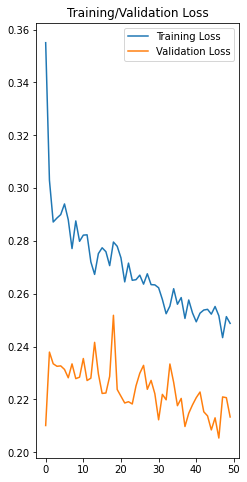

Epoch 1/50
47/47 [==============================] - 1s 27ms/step - loss: 0.2467 - mae: 0.2088 - rmse: 0.2505 - val_loss: 0.3331 - val_mae: 0.2609 - val_rmse: 0.3331
Epoch 2/50
47/47 [==============================] - 0s 9ms/step - loss: 0.2414 - mae: 0.2047 - rmse: 0.2456 - val_loss: 0.3624 - val_mae: 0.2870 - val_rmse: 0.3624
Epoch 3/50
47/47 [==============================] - 0s 10ms/step - loss: 0.2379 - mae: 0.2026 - rmse: 0.2422 - val_loss: 0.3434 - val_mae: 0.2590 - val_rmse: 0.3434
Epoch 4/50
47/47 [==============================] - 0s 9ms/step - loss: 0.2434 - mae: 0.2072 - rmse: 0.2475 - val_loss: 0.4079 - val_mae: 0.3360 - val_rmse: 0.4079
Epoch 5/50
47/47 [==============================] - 0s 10ms/step - loss: 0.2407 - mae: 0.2035 - rmse: 0.2449 - val_loss: 0.3975 - val_mae: 0.3246 - val_rmse: 0.3975

Epoch 00005: val_loss did not improve from 0.20848
Epoch 6/50
47/47 [==============================] - 0s 9ms/step - loss: 0.2412 - mae: 0.2068 - rmse: 0.2449 - val_loss: 0.375

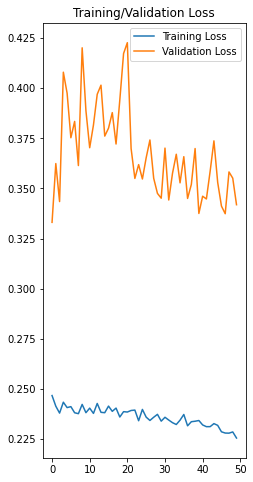

[array([[128.24304]], dtype=float32), array([[213.72862]], dtype=float32), array([[242.14871]], dtype=float32), array([[192.5093]], dtype=float32), array([[206.23784]], dtype=float32), array([[235.18842]], dtype=float32), array([[185.97272]], dtype=float32), array([[178.9927]], dtype=float32), array([[218.22638]], dtype=float32), array([[238.6108]], dtype=float32), array([[220.85275]], dtype=float32), array([[224.30545]], dtype=float32), array([[229.20654]], dtype=float32), array([[206.78836]], dtype=float32), array([[202.52061]], dtype=float32)]
[128.24304, 213.72862, 242.14871, 192.5093, 206.23784, 235.18842, 185.97272, 178.9927, 218.22638, 238.6108, 220.85275, 224.30545, 229.20654, 206.78836, 202.52061]


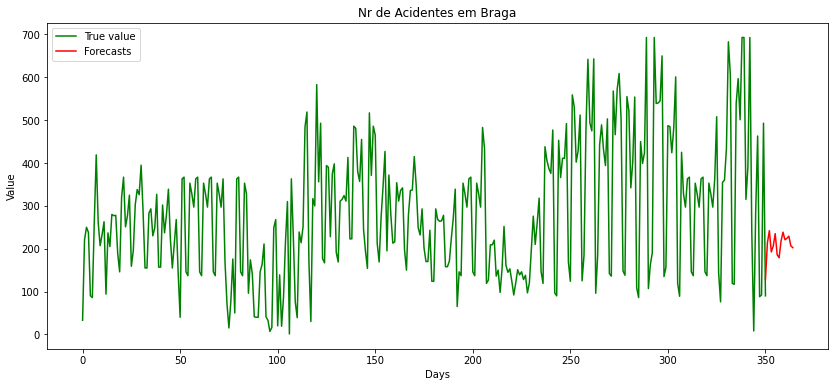

Epoch 1/100
16/16 [==============================] - 4s 68ms/step - loss: 0.2922 - mae: 0.2549 - rmse: 0.2923 - val_loss: 0.3248 - val_mae: 0.2859 - val_rmse: 0.3023
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.2563 - mae: 0.2053 - rmse: 0.2564 - val_loss: 0.4353 - val_mae: 0.3922 - val_rmse: 0.4118
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.2457 - mae: 0.1997 - rmse: 0.2457 - val_loss: 0.4079 - val_mae: 0.3610 - val_rmse: 0.3851
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.2431 - mae: 0.2013 - rmse: 0.2432 - val_loss: 0.4271 - val_mae: 0.3843 - val_rmse: 0.4050
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.2384 - mae: 0.1948 - rmse: 0.2385 - val_loss: 0.4208 - val_mae: 0.3778 - val_rmse: 0.3991

Epoch 00005: val_loss improved from inf to 0.42082, saving model to my_model_5_0.421.h5
Epoch 6/100
16/16 [==============================] - 0s 15ms/step - loss: 0.2381 

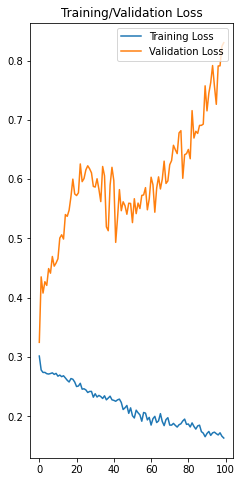

Epoch 1/100
31/31 [==============================] - 2s 11ms/step - loss: 0.3643 - mae: 0.3173 - rmse: 0.3643 - val_loss: 0.1979 - val_mae: 0.1736 - val_rmse: 0.1927
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.2934 - mae: 0.2491 - rmse: 0.2934 - val_loss: 0.2225 - val_mae: 0.1919 - val_rmse: 0.2323
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.2821 - mae: 0.2375 - rmse: 0.2821 - val_loss: 0.2142 - val_mae: 0.1854 - val_rmse: 0.2239
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.2869 - mae: 0.2408 - rmse: 0.2869 - val_loss: 0.2132 - val_mae: 0.1869 - val_rmse: 0.2190
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.2790 - mae: 0.2368 - rmse: 0.2790 - val_loss: 0.2135 - val_mae: 0.1865 - val_rmse: 0.2223

Epoch 00005: val_loss improved from 0.42082 to 0.21354, saving model to my_model_5_0.214.h5
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 0.2761 

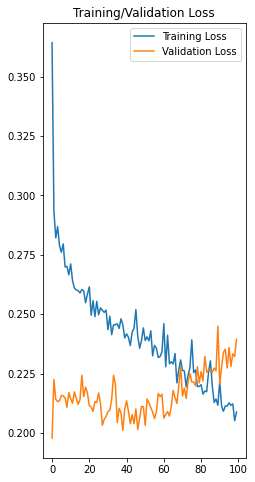

Epoch 1/100
47/47 [==============================] - 2s 36ms/step - loss: 0.2255 - mae: 0.1876 - rmse: 0.2294 - val_loss: 0.3607 - val_mae: 0.3004 - val_rmse: 0.3607
Epoch 2/100
47/47 [==============================] - 0s 10ms/step - loss: 0.2129 - mae: 0.1785 - rmse: 0.2165 - val_loss: 0.4094 - val_mae: 0.3488 - val_rmse: 0.4094
Epoch 3/100
47/47 [==============================] - 1s 11ms/step - loss: 0.2148 - mae: 0.1781 - rmse: 0.2190 - val_loss: 0.4144 - val_mae: 0.3575 - val_rmse: 0.4144
Epoch 4/100
47/47 [==============================] - 0s 10ms/step - loss: 0.2122 - mae: 0.1756 - rmse: 0.2169 - val_loss: 0.4093 - val_mae: 0.3488 - val_rmse: 0.4093
Epoch 5/100
47/47 [==============================] - 0s 10ms/step - loss: 0.2155 - mae: 0.1787 - rmse: 0.2196 - val_loss: 0.4212 - val_mae: 0.3577 - val_rmse: 0.4212

Epoch 00005: val_loss did not improve from 0.20389
Epoch 6/100
47/47 [==============================] - 0s 10ms/step - loss: 0.2110 - mae: 0.1743 - rmse: 0.2147 - val_lo

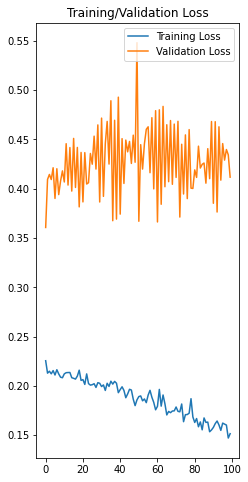

[array([[72.90155]], dtype=float32), array([[254.69156]], dtype=float32), array([[297.87424]], dtype=float32), array([[328.35373]], dtype=float32), array([[308.50552]], dtype=float32), array([[458.5965]], dtype=float32), array([[318.34396]], dtype=float32), array([[109.219]], dtype=float32), array([[268.2568]], dtype=float32), array([[378.04736]], dtype=float32), array([[367.4798]], dtype=float32), array([[402.15668]], dtype=float32), array([[463.83176]], dtype=float32), array([[275.18695]], dtype=float32), array([[163.32607]], dtype=float32)]
[72.90155, 254.69156, 297.87424, 328.35373, 308.50552, 458.5965, 318.34396, 109.219, 268.2568, 378.04736, 367.4798, 402.15668, 463.83176, 275.18695, 163.32607]


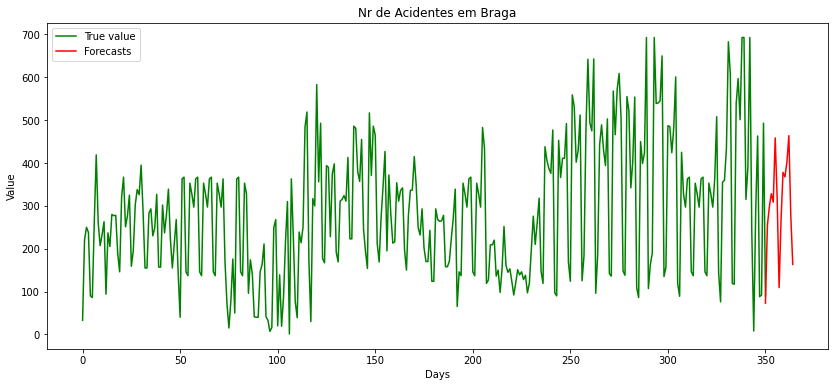

Epoch 1/60
16/16 [==============================] - 4s 68ms/step - loss: 0.2900 - mae: 0.2527 - rmse: 0.2903 - val_loss: 0.3155 - val_mae: 0.2817 - val_rmse: 0.2946
Epoch 2/60
16/16 [==============================] - 0s 13ms/step - loss: 0.2233 - mae: 0.1971 - rmse: 0.2234 - val_loss: 0.4405 - val_mae: 0.3985 - val_rmse: 0.4167
Epoch 3/60
16/16 [==============================] - 0s 14ms/step - loss: 0.2206 - mae: 0.1859 - rmse: 0.2210 - val_loss: 0.3874 - val_mae: 0.3478 - val_rmse: 0.3645
Epoch 4/60
16/16 [==============================] - 0s 15ms/step - loss: 0.2169 - mae: 0.1850 - rmse: 0.2171 - val_loss: 0.4258 - val_mae: 0.3830 - val_rmse: 0.4032
Epoch 5/60
16/16 [==============================] - 0s 14ms/step - loss: 0.2141 - mae: 0.1862 - rmse: 0.2144 - val_loss: 0.4044 - val_mae: 0.3618 - val_rmse: 0.3820

Epoch 00005: val_loss improved from inf to 0.40438, saving model to my_model_5_0.404.h5
Epoch 6/60
16/16 [==============================] - 0s 14ms/step - loss: 0.2080 - mae:

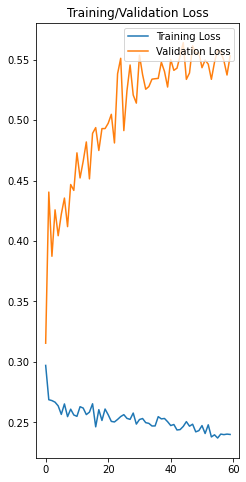

Epoch 1/60
31/31 [==============================] - 0s 14ms/step - loss: 0.3288 - mae: 0.2821 - rmse: 0.3278 - val_loss: 0.2457 - val_mae: 0.2084 - val_rmse: 0.2431
Epoch 2/60
31/31 [==============================] - 0s 12ms/step - loss: 0.3091 - mae: 0.2754 - rmse: 0.3079 - val_loss: 0.2552 - val_mae: 0.2147 - val_rmse: 0.2556
Epoch 3/60
31/31 [==============================] - 0s 12ms/step - loss: 0.2998 - mae: 0.2631 - rmse: 0.2986 - val_loss: 0.2566 - val_mae: 0.2179 - val_rmse: 0.2595
Epoch 4/60
31/31 [==============================] - 0s 12ms/step - loss: 0.3041 - mae: 0.2663 - rmse: 0.3027 - val_loss: 0.2589 - val_mae: 0.2252 - val_rmse: 0.2620
Epoch 5/60
31/31 [==============================] - 0s 13ms/step - loss: 0.3008 - mae: 0.2625 - rmse: 0.2997 - val_loss: 0.2581 - val_mae: 0.2233 - val_rmse: 0.2637

Epoch 00005: val_loss improved from 0.40438 to 0.25814, saving model to my_model_5_0.258.h5
Epoch 6/60
31/31 [==============================] - 0s 11ms/step - loss: 0.3009 - 

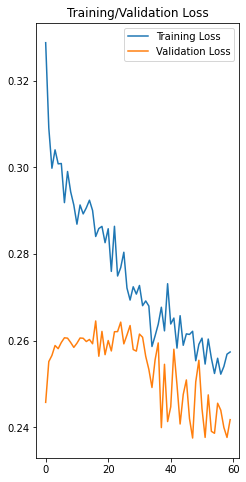

Epoch 1/60
47/47 [==============================] - 1s 30ms/step - loss: 0.2540 - mae: 0.2165 - rmse: 0.2577 - val_loss: 0.4853 - val_mae: 0.4422 - val_rmse: 0.4853
Epoch 2/60
47/47 [==============================] - 1s 12ms/step - loss: 0.2697 - mae: 0.2306 - rmse: 0.2722 - val_loss: 0.4322 - val_mae: 0.3764 - val_rmse: 0.4322
Epoch 3/60
47/47 [==============================] - 1s 11ms/step - loss: 0.2566 - mae: 0.2222 - rmse: 0.2601 - val_loss: 0.3861 - val_mae: 0.3330 - val_rmse: 0.3861
Epoch 4/60
47/47 [==============================] - 1s 12ms/step - loss: 0.2542 - mae: 0.2184 - rmse: 0.2582 - val_loss: 0.4361 - val_mae: 0.3824 - val_rmse: 0.4361
Epoch 5/60
47/47 [==============================] - 1s 12ms/step - loss: 0.2504 - mae: 0.2171 - rmse: 0.2536 - val_loss: 0.4435 - val_mae: 0.3928 - val_rmse: 0.4435

Epoch 00005: val_loss did not improve from 0.23860
Epoch 6/60
47/47 [==============================] - 1s 12ms/step - loss: 0.2528 - mae: 0.2189 - rmse: 0.2560 - val_loss: 0.

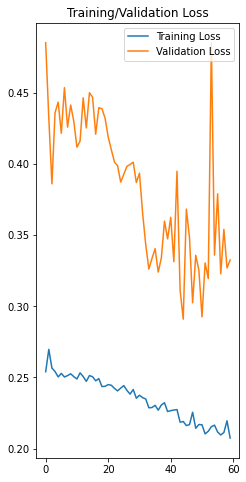

[array([[41.67761]], dtype=float32), array([[239.5484]], dtype=float32), array([[238.35081]], dtype=float32), array([[142.88857]], dtype=float32), array([[185.02211]], dtype=float32), array([[218.31476]], dtype=float32), array([[201.26108]], dtype=float32), array([[146.61017]], dtype=float32), array([[215.86769]], dtype=float32), array([[208.39098]], dtype=float32), array([[172.72281]], dtype=float32), array([[195.55397]], dtype=float32), array([[208.71637]], dtype=float32), array([[189.72546]], dtype=float32), array([[181.83829]], dtype=float32)]
[41.67761, 239.5484, 238.35081, 142.88857, 185.02211, 218.31476, 201.26108, 146.61017, 215.86769, 208.39098, 172.72281, 195.55397, 208.71637, 189.72546, 181.83829]


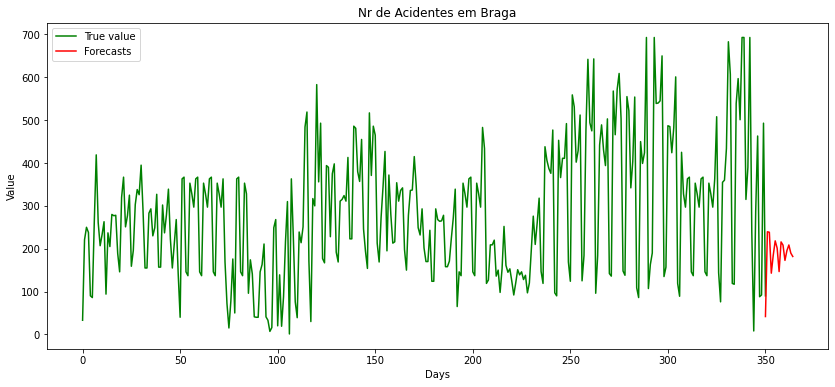

Epoch 1/90
16/16 [==============================] - 5s 66ms/step - loss: 0.3010 - mae: 0.2619 - rmse: 0.3014 - val_loss: 0.3060 - val_mae: 0.2750 - val_rmse: 0.2864
Epoch 2/90
16/16 [==============================] - 0s 14ms/step - loss: 0.2302 - mae: 0.2042 - rmse: 0.2304 - val_loss: 0.4549 - val_mae: 0.4156 - val_rmse: 0.4315
Epoch 3/90
16/16 [==============================] - 0s 14ms/step - loss: 0.2204 - mae: 0.1844 - rmse: 0.2208 - val_loss: 0.3739 - val_mae: 0.3364 - val_rmse: 0.3514
Epoch 4/90
16/16 [==============================] - 0s 15ms/step - loss: 0.2157 - mae: 0.1877 - rmse: 0.2159 - val_loss: 0.4406 - val_mae: 0.4004 - val_rmse: 0.4183
Epoch 5/90
16/16 [==============================] - 0s 16ms/step - loss: 0.2127 - mae: 0.1834 - rmse: 0.2129 - val_loss: 0.4140 - val_mae: 0.3705 - val_rmse: 0.3918

Epoch 00005: val_loss improved from inf to 0.41404, saving model to my_model_5_0.414.h5
Epoch 6/90
16/16 [==============================] - 0s 14ms/step - loss: 0.2119 - mae:

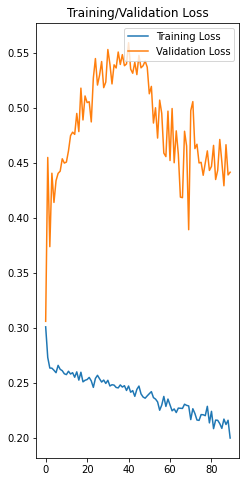

Epoch 1/90
31/31 [==============================] - 0s 16ms/step - loss: 0.3284 - mae: 0.2869 - rmse: 0.3275 - val_loss: 0.2264 - val_mae: 0.2062 - val_rmse: 0.2256
Epoch 2/90
31/31 [==============================] - 0s 13ms/step - loss: 0.2907 - mae: 0.2519 - rmse: 0.2896 - val_loss: 0.2461 - val_mae: 0.2149 - val_rmse: 0.2640
Epoch 3/90
31/31 [==============================] - 0s 13ms/step - loss: 0.2814 - mae: 0.2393 - rmse: 0.2804 - val_loss: 0.2542 - val_mae: 0.2186 - val_rmse: 0.2747
Epoch 4/90
31/31 [==============================] - 0s 13ms/step - loss: 0.2834 - mae: 0.2452 - rmse: 0.2825 - val_loss: 0.2463 - val_mae: 0.2194 - val_rmse: 0.2547
Epoch 5/90
31/31 [==============================] - 0s 12ms/step - loss: 0.2702 - mae: 0.2297 - rmse: 0.2694 - val_loss: 0.2488 - val_mae: 0.2118 - val_rmse: 0.2678

Epoch 00005: val_loss improved from 0.38926 to 0.24881, saving model to my_model_5_0.249.h5
Epoch 6/90
31/31 [==============================] - 0s 12ms/step - loss: 0.2836 - 

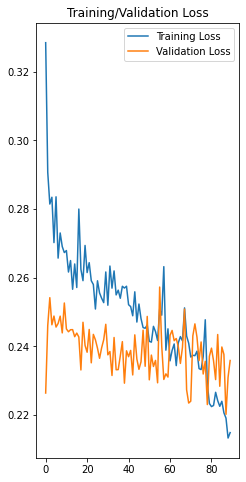

Epoch 1/90
47/47 [==============================] - 1s 31ms/step - loss: 0.2344 - mae: 0.2029 - rmse: 0.2384 - val_loss: 0.5005 - val_mae: 0.4129 - val_rmse: 0.5005
Epoch 2/90
47/47 [==============================] - 1s 12ms/step - loss: 0.2451 - mae: 0.2109 - rmse: 0.2477 - val_loss: 0.4723 - val_mae: 0.3983 - val_rmse: 0.4723
Epoch 3/90
47/47 [==============================] - 1s 12ms/step - loss: 0.2284 - mae: 0.1968 - rmse: 0.2312 - val_loss: 0.4255 - val_mae: 0.3681 - val_rmse: 0.4255
Epoch 4/90
47/47 [==============================] - 1s 12ms/step - loss: 0.2328 - mae: 0.2032 - rmse: 0.2352 - val_loss: 0.4788 - val_mae: 0.4213 - val_rmse: 0.4788
Epoch 5/90
47/47 [==============================] - 1s 13ms/step - loss: 0.2315 - mae: 0.2010 - rmse: 0.2335 - val_loss: 0.4381 - val_mae: 0.3829 - val_rmse: 0.4381

Epoch 00005: val_loss did not improve from 0.22347
Epoch 6/90
47/47 [==============================] - 1s 11ms/step - loss: 0.2337 - mae: 0.2019 - rmse: 0.2364 - val_loss: 0.

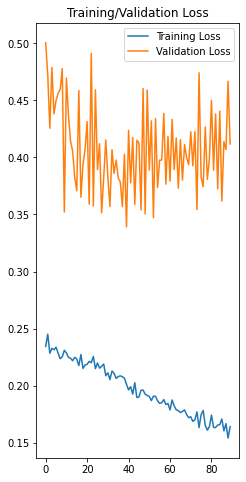

[array([[32.877705]], dtype=float32), array([[151.51561]], dtype=float32), array([[135.10837]], dtype=float32), array([[23.887987]], dtype=float32), array([[65.14869]], dtype=float32), array([[239.00018]], dtype=float32), array([[202.37285]], dtype=float32), array([[160.84256]], dtype=float32), array([[228.13939]], dtype=float32), array([[214.7363]], dtype=float32), array([[158.71088]], dtype=float32), array([[125.944336]], dtype=float32), array([[255.18335]], dtype=float32), array([[224.27971]], dtype=float32), array([[212.62056]], dtype=float32)]
[32.877705, 151.51561, 135.10837, 23.887987, 65.14869, 239.00018, 202.37285, 160.84256, 228.13939, 214.7363, 158.71088, 125.944336, 255.18335, 224.27971, 212.62056]


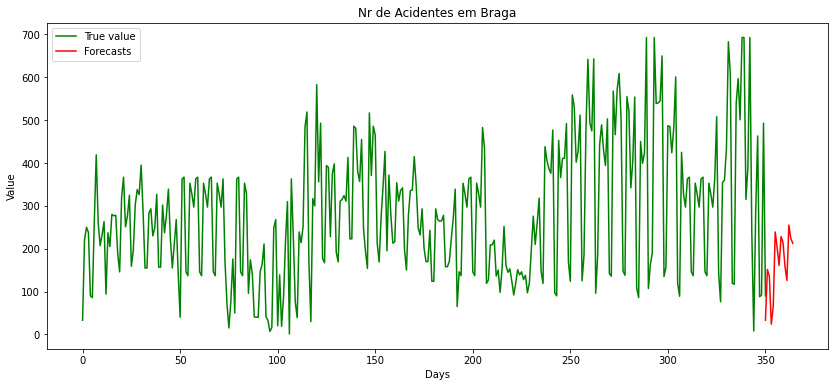

Epoch 1/120
16/16 [==============================] - 4s 68ms/step - loss: 0.3056 - mae: 0.2668 - rmse: 0.3059 - val_loss: 0.3136 - val_mae: 0.2800 - val_rmse: 0.2929
Epoch 2/120
16/16 [==============================] - 0s 15ms/step - loss: 0.2234 - mae: 0.1957 - rmse: 0.2236 - val_loss: 0.4503 - val_mae: 0.4103 - val_rmse: 0.4268
Epoch 3/120
16/16 [==============================] - 0s 15ms/step - loss: 0.2166 - mae: 0.1806 - rmse: 0.2170 - val_loss: 0.3753 - val_mae: 0.3376 - val_rmse: 0.3527
Epoch 4/120
16/16 [==============================] - 0s 14ms/step - loss: 0.2152 - mae: 0.1870 - rmse: 0.2154 - val_loss: 0.4284 - val_mae: 0.3865 - val_rmse: 0.4058
Epoch 5/120
16/16 [==============================] - 0s 14ms/step - loss: 0.2131 - mae: 0.1846 - rmse: 0.2135 - val_loss: 0.4164 - val_mae: 0.3731 - val_rmse: 0.3939

Epoch 00005: val_loss improved from inf to 0.41643, saving model to my_model_5_0.416.h5
Epoch 6/120
16/16 [==============================] - 0s 16ms/step - loss: 0.2168 

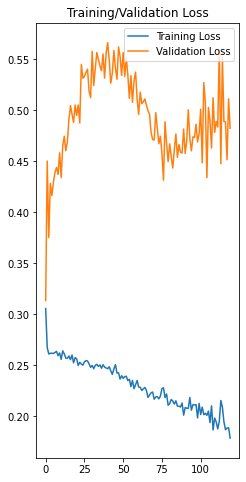

Epoch 1/120
31/31 [==============================] - 0s 14ms/step - loss: 0.3210 - mae: 0.2846 - rmse: 0.3206 - val_loss: 0.2156 - val_mae: 0.1986 - val_rmse: 0.2153
Epoch 2/120
31/31 [==============================] - 0s 13ms/step - loss: 0.3028 - mae: 0.2614 - rmse: 0.3018 - val_loss: 0.2529 - val_mae: 0.2081 - val_rmse: 0.2857
Epoch 3/120
31/31 [==============================] - 0s 14ms/step - loss: 0.3010 - mae: 0.2582 - rmse: 0.2999 - val_loss: 0.2482 - val_mae: 0.2267 - val_rmse: 0.2636
Epoch 4/120
31/31 [==============================] - 0s 13ms/step - loss: 0.2749 - mae: 0.2371 - rmse: 0.2740 - val_loss: 0.2475 - val_mae: 0.2124 - val_rmse: 0.2675
Epoch 5/120
31/31 [==============================] - 0s 13ms/step - loss: 0.2687 - mae: 0.2324 - rmse: 0.2677 - val_loss: 0.2449 - val_mae: 0.2151 - val_rmse: 0.2622

Epoch 00005: val_loss improved from 0.41643 to 0.24489, saving model to my_model_5_0.245.h5
Epoch 6/120
31/31 [==============================] - 0s 13ms/step - loss: 0.2

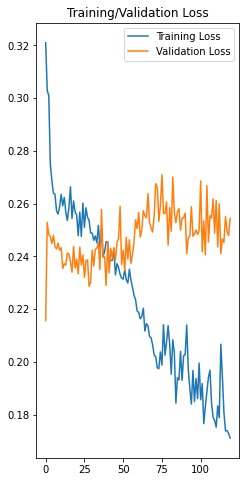

Epoch 1/120
47/47 [==============================] - 1s 31ms/step - loss: 0.2023 - mae: 0.1723 - rmse: 0.2027 - val_loss: 0.3919 - val_mae: 0.3443 - val_rmse: 0.3919
Epoch 2/120
47/47 [==============================] - 1s 12ms/step - loss: 0.2117 - mae: 0.1814 - rmse: 0.2126 - val_loss: 0.4563 - val_mae: 0.4073 - val_rmse: 0.4563
Epoch 3/120
47/47 [==============================] - 1s 13ms/step - loss: 0.2042 - mae: 0.1767 - rmse: 0.2043 - val_loss: 0.3704 - val_mae: 0.3400 - val_rmse: 0.3704
Epoch 4/120
47/47 [==============================] - 1s 12ms/step - loss: 0.1993 - mae: 0.1736 - rmse: 0.1991 - val_loss: 0.3959 - val_mae: 0.3456 - val_rmse: 0.3959
Epoch 5/120
47/47 [==============================] - 1s 12ms/step - loss: 0.2096 - mae: 0.1812 - rmse: 0.2093 - val_loss: 0.3697 - val_mae: 0.3130 - val_rmse: 0.3697

Epoch 00005: val_loss did not improve from 0.22903
Epoch 6/120
47/47 [==============================] - 1s 12ms/step - loss: 0.2058 - mae: 0.1791 - rmse: 0.2055 - val_lo

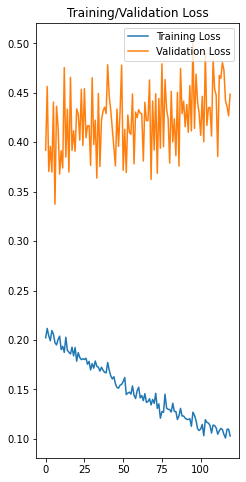

[array([[75.09068]], dtype=float32), array([[126.07338]], dtype=float32), array([[157.15176]], dtype=float32), array([[177.58711]], dtype=float32), array([[89.74223]], dtype=float32), array([[340.7307]], dtype=float32), array([[299.03894]], dtype=float32), array([[149.9816]], dtype=float32), array([[275.70624]], dtype=float32), array([[281.70297]], dtype=float32), array([[201.09138]], dtype=float32), array([[149.78796]], dtype=float32), array([[195.08354]], dtype=float32), array([[237.4686]], dtype=float32), array([[271.6793]], dtype=float32)]
[75.09068, 126.07338, 157.15176, 177.58711, 89.74223, 340.7307, 299.03894, 149.9816, 275.70624, 281.70297, 201.09138, 149.78796, 195.08354, 237.4686, 271.6793]


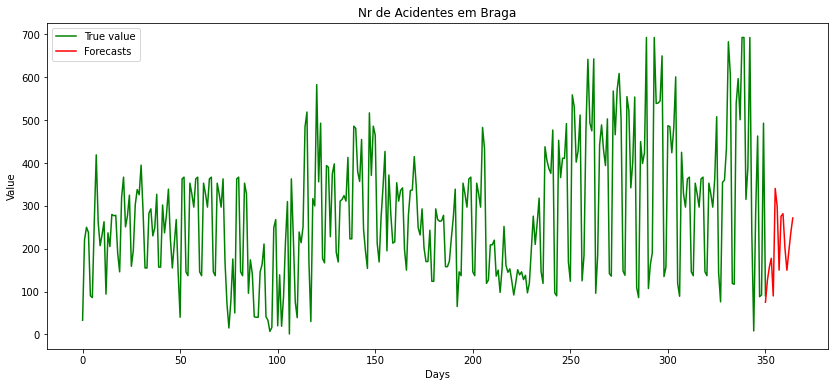

Epoch 1/50
10/10 [==============================] - 4s 117ms/step - loss: 0.3160 - mae: 0.2661 - rmse: 0.3164 - val_loss: 0.3358 - val_mae: 0.2830 - val_rmse: 0.3358
Epoch 2/50
10/10 [==============================] - 0s 21ms/step - loss: 0.2373 - mae: 0.2120 - rmse: 0.2378 - val_loss: 0.4482 - val_mae: 0.3982 - val_rmse: 0.4482
Epoch 3/50
10/10 [==============================] - 0s 21ms/step - loss: 0.2272 - mae: 0.1939 - rmse: 0.2277 - val_loss: 0.4129 - val_mae: 0.3578 - val_rmse: 0.4129
Epoch 4/50
10/10 [==============================] - 0s 21ms/step - loss: 0.2315 - mae: 0.2007 - rmse: 0.2321 - val_loss: 0.4090 - val_mae: 0.3540 - val_rmse: 0.4090
Epoch 5/50
10/10 [==============================] - 0s 21ms/step - loss: 0.2236 - mae: 0.1914 - rmse: 0.2243 - val_loss: 0.4272 - val_mae: 0.3761 - val_rmse: 0.4272

Epoch 00005: val_loss improved from inf to 0.42722, saving model to my_model_5_0.427.h5
Epoch 6/50
10/10 [==============================] - 0s 20ms/step - loss: 0.2219 - mae

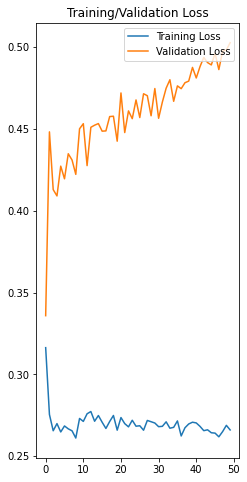

Epoch 1/50
20/20 [==============================] - 0s 19ms/step - loss: 0.3417 - mae: 0.2961 - rmse: 0.3347 - val_loss: 0.2459 - val_mae: 0.2126 - val_rmse: 0.2459
Epoch 2/50
20/20 [==============================] - 0s 16ms/step - loss: 0.3221 - mae: 0.2764 - rmse: 0.3101 - val_loss: 0.2587 - val_mae: 0.2193 - val_rmse: 0.2587
Epoch 3/50
20/20 [==============================] - 0s 16ms/step - loss: 0.3099 - mae: 0.2662 - rmse: 0.2966 - val_loss: 0.2741 - val_mae: 0.2274 - val_rmse: 0.2741
Epoch 4/50
20/20 [==============================] - 0s 17ms/step - loss: 0.3149 - mae: 0.2689 - rmse: 0.3023 - val_loss: 0.2687 - val_mae: 0.2212 - val_rmse: 0.2687
Epoch 5/50
20/20 [==============================] - 0s 17ms/step - loss: 0.3114 - mae: 0.2678 - rmse: 0.2978 - val_loss: 0.2734 - val_mae: 0.2236 - val_rmse: 0.2734

Epoch 00005: val_loss improved from 0.42722 to 0.27337, saving model to my_model_5_0.273.h5
Epoch 6/50
20/20 [==============================] - 0s 17ms/step - loss: 0.3096 - 

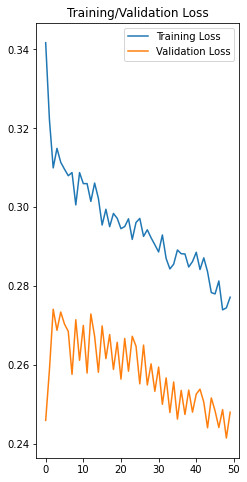

Epoch 1/50
29/29 [==============================] - 1s 18ms/step - loss: 0.2707 - mae: 0.2268 - rmse: 0.2724 - val_loss: 0.4530 - val_mae: 0.3814 - val_rmse: 0.4465
Epoch 2/50
29/29 [==============================] - 0s 16ms/step - loss: 0.2659 - mae: 0.2261 - rmse: 0.2675 - val_loss: 0.3946 - val_mae: 0.3260 - val_rmse: 0.3775
Epoch 3/50
29/29 [==============================] - 0s 15ms/step - loss: 0.2683 - mae: 0.2272 - rmse: 0.2701 - val_loss: 0.4050 - val_mae: 0.3407 - val_rmse: 0.3935
Epoch 4/50
29/29 [==============================] - 0s 15ms/step - loss: 0.2660 - mae: 0.2266 - rmse: 0.2675 - val_loss: 0.4044 - val_mae: 0.3265 - val_rmse: 0.3860
Epoch 5/50
29/29 [==============================] - 0s 16ms/step - loss: 0.2634 - mae: 0.2211 - rmse: 0.2650 - val_loss: 0.3961 - val_mae: 0.3354 - val_rmse: 0.3785

Epoch 00005: val_loss did not improve from 0.24795
Epoch 6/50
29/29 [==============================] - 1s 18ms/step - loss: 0.2650 - mae: 0.2231 - rmse: 0.2666 - val_loss: 0.

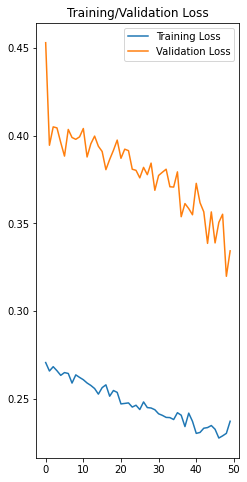

[array([[111.47052]], dtype=float32), array([[241.64629]], dtype=float32), array([[258.6651]], dtype=float32), array([[266.68643]], dtype=float32), array([[227.94102]], dtype=float32), array([[273.87518]], dtype=float32), array([[297.29794]], dtype=float32), array([[197.41496]], dtype=float32), array([[223.19975]], dtype=float32), array([[280.21057]], dtype=float32), array([[289.6278]], dtype=float32), array([[283.90958]], dtype=float32), array([[295.0192]], dtype=float32), array([[279.1127]], dtype=float32), array([[234.36209]], dtype=float32)]
[111.47052, 241.64629, 258.6651, 266.68643, 227.94102, 273.87518, 297.29794, 197.41496, 223.19975, 280.21057, 289.6278, 283.90958, 295.0192, 279.1127, 234.36209]


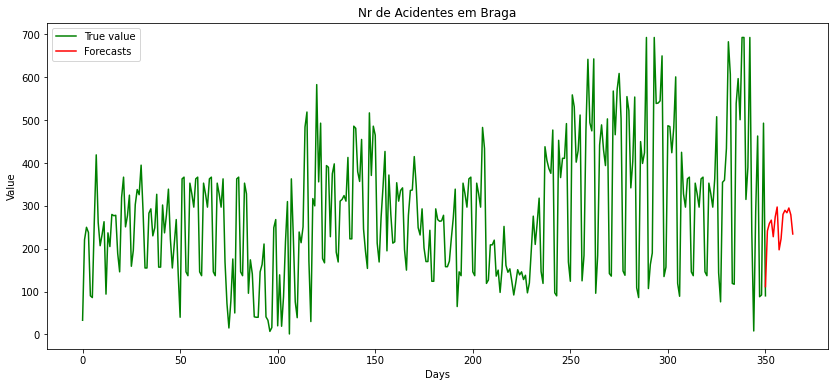

Epoch 1/90
10/10 [==============================] - 4s 118ms/step - loss: 0.2947 - mae: 0.2493 - rmse: 0.2954 - val_loss: 0.3084 - val_mae: 0.2575 - val_rmse: 0.3084
Epoch 2/90
10/10 [==============================] - 0s 23ms/step - loss: 0.2420 - mae: 0.2161 - rmse: 0.2425 - val_loss: 0.4483 - val_mae: 0.3967 - val_rmse: 0.4483
Epoch 3/90
10/10 [==============================] - 0s 21ms/step - loss: 0.2275 - mae: 0.1904 - rmse: 0.2280 - val_loss: 0.3880 - val_mae: 0.3333 - val_rmse: 0.3880
Epoch 4/90
10/10 [==============================] - 0s 21ms/step - loss: 0.2270 - mae: 0.1987 - rmse: 0.2276 - val_loss: 0.4025 - val_mae: 0.3463 - val_rmse: 0.4025
Epoch 5/90
10/10 [==============================] - 0s 21ms/step - loss: 0.2315 - mae: 0.1974 - rmse: 0.2320 - val_loss: 0.4322 - val_mae: 0.3808 - val_rmse: 0.4322

Epoch 00005: val_loss improved from inf to 0.43218, saving model to my_model_5_0.432.h5
Epoch 6/90
10/10 [==============================] - 0s 23ms/step - loss: 0.2240 - mae

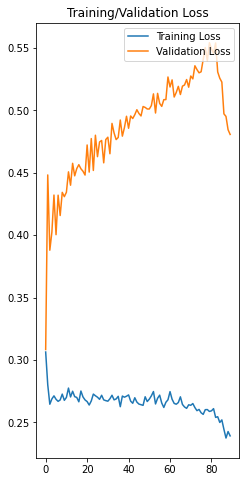

Epoch 1/90
20/20 [==============================] - 0s 20ms/step - loss: 0.3015 - mae: 0.2512 - rmse: 0.2888 - val_loss: 0.2858 - val_mae: 0.2422 - val_rmse: 0.2858
Epoch 2/90
20/20 [==============================] - 0s 19ms/step - loss: 0.3114 - mae: 0.2632 - rmse: 0.2986 - val_loss: 0.2583 - val_mae: 0.2148 - val_rmse: 0.2583
Epoch 3/90
20/20 [==============================] - 0s 16ms/step - loss: 0.3065 - mae: 0.2558 - rmse: 0.2948 - val_loss: 0.2609 - val_mae: 0.2355 - val_rmse: 0.2609
Epoch 4/90
20/20 [==============================] - 0s 16ms/step - loss: 0.2924 - mae: 0.2465 - rmse: 0.2804 - val_loss: 0.2649 - val_mae: 0.2282 - val_rmse: 0.2649
Epoch 5/90
20/20 [==============================] - 0s 19ms/step - loss: 0.2872 - mae: 0.2438 - rmse: 0.2754 - val_loss: 0.2535 - val_mae: 0.2163 - val_rmse: 0.2535

Epoch 00005: val_loss improved from 0.43090 to 0.25348, saving model to my_model_5_0.253.h5
Epoch 6/90
20/20 [==============================] - 0s 17ms/step - loss: 0.2938 - 

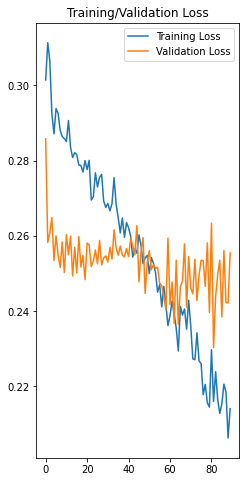

Epoch 1/90
29/29 [==============================] - 1s 19ms/step - loss: 0.2243 - mae: 0.1839 - rmse: 0.2268 - val_loss: 0.4851 - val_mae: 0.3935 - val_rmse: 0.3952
Epoch 2/90
29/29 [==============================] - 0s 17ms/step - loss: 0.2332 - mae: 0.1945 - rmse: 0.2350 - val_loss: 0.3599 - val_mae: 0.2940 - val_rmse: 0.3001
Epoch 3/90
29/29 [==============================] - 0s 16ms/step - loss: 0.2344 - mae: 0.1932 - rmse: 0.2367 - val_loss: 0.3532 - val_mae: 0.2870 - val_rmse: 0.3123
Epoch 4/90
29/29 [==============================] - 1s 18ms/step - loss: 0.2213 - mae: 0.1810 - rmse: 0.2234 - val_loss: 0.3550 - val_mae: 0.2812 - val_rmse: 0.2849
Epoch 5/90
29/29 [==============================] - 1s 17ms/step - loss: 0.2202 - mae: 0.1793 - rmse: 0.2224 - val_loss: 0.3344 - val_mae: 0.2733 - val_rmse: 0.2765

Epoch 00005: val_loss did not improve from 0.23654
Epoch 6/90
29/29 [==============================] - 0s 17ms/step - loss: 0.2193 - mae: 0.1770 - rmse: 0.2213 - val_loss: 0.

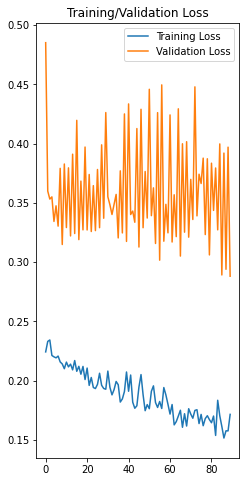

[array([[60.820045]], dtype=float32), array([[147.40045]], dtype=float32), array([[157.89398]], dtype=float32), array([[195.68155]], dtype=float32), array([[149.57674]], dtype=float32), array([[218.79831]], dtype=float32), array([[351.6388]], dtype=float32), array([[198.45015]], dtype=float32), array([[151.2856]], dtype=float32), array([[417.1718]], dtype=float32), array([[407.58734]], dtype=float32), array([[220.86465]], dtype=float32), array([[189.28094]], dtype=float32), array([[361.08084]], dtype=float32), array([[311.16403]], dtype=float32)]
[60.820045, 147.40045, 157.89398, 195.68155, 149.57674, 218.79831, 351.6388, 198.45015, 151.2856, 417.1718, 407.58734, 220.86465, 189.28094, 361.08084, 311.16403]


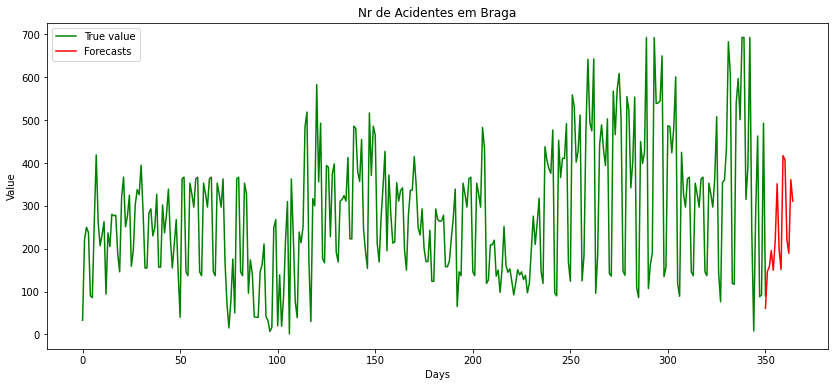

Epoch 1/120
10/10 [==============================] - 4s 115ms/step - loss: 0.3260 - mae: 0.2763 - rmse: 0.3260 - val_loss: 0.3455 - val_mae: 0.2934 - val_rmse: 0.3455
Epoch 2/120
10/10 [==============================] - 0s 22ms/step - loss: 0.2441 - mae: 0.2130 - rmse: 0.2448 - val_loss: 0.4545 - val_mae: 0.4063 - val_rmse: 0.4545
Epoch 3/120
10/10 [==============================] - 0s 21ms/step - loss: 0.2294 - mae: 0.1956 - rmse: 0.2297 - val_loss: 0.4252 - val_mae: 0.3734 - val_rmse: 0.4252
Epoch 4/120
10/10 [==============================] - 0s 21ms/step - loss: 0.2359 - mae: 0.2027 - rmse: 0.2364 - val_loss: 0.4082 - val_mae: 0.3540 - val_rmse: 0.4082
Epoch 5/120
10/10 [==============================] - 0s 18ms/step - loss: 0.2247 - mae: 0.1963 - rmse: 0.2251 - val_loss: 0.4380 - val_mae: 0.3895 - val_rmse: 0.4380

Epoch 00005: val_loss improved from inf to 0.43805, saving model to my_model_5_0.438.h5
Epoch 6/120
10/10 [==============================] - 0s 21ms/step - loss: 0.2242

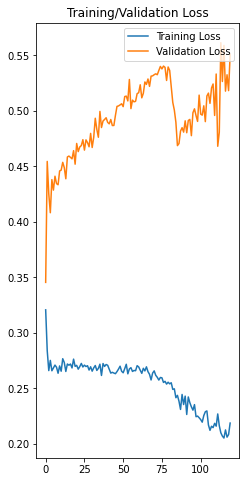

Epoch 1/120
20/20 [==============================] - 0s 21ms/step - loss: 0.3246 - mae: 0.2707 - rmse: 0.3198 - val_loss: 0.2985 - val_mae: 0.2454 - val_rmse: 0.2985
Epoch 2/120
20/20 [==============================] - 0s 19ms/step - loss: 0.3129 - mae: 0.2724 - rmse: 0.3035 - val_loss: 0.2469 - val_mae: 0.2253 - val_rmse: 0.2469
Epoch 3/120
20/20 [==============================] - 0s 17ms/step - loss: 0.3016 - mae: 0.2528 - rmse: 0.2899 - val_loss: 0.2662 - val_mae: 0.2342 - val_rmse: 0.2662
Epoch 4/120
20/20 [==============================] - 0s 17ms/step - loss: 0.2877 - mae: 0.2450 - rmse: 0.2765 - val_loss: 0.2587 - val_mae: 0.2283 - val_rmse: 0.2587
Epoch 5/120
20/20 [==============================] - 0s 18ms/step - loss: 0.2887 - mae: 0.2415 - rmse: 0.2770 - val_loss: 0.2606 - val_mae: 0.2372 - val_rmse: 0.2606

Epoch 00005: val_loss improved from 0.43805 to 0.26062, saving model to my_model_5_0.261.h5
Epoch 6/120
20/20 [==============================] - 0s 17ms/step - loss: 0.2

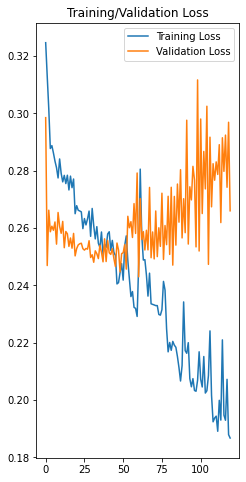

Epoch 1/120
29/29 [==============================] - 1s 18ms/step - loss: 0.2356 - mae: 0.1928 - rmse: 0.2381 - val_loss: 0.3736 - val_mae: 0.3029 - val_rmse: 0.3484
Epoch 2/120
29/29 [==============================] - 1s 18ms/step - loss: 0.2228 - mae: 0.1846 - rmse: 0.2250 - val_loss: 0.3854 - val_mae: 0.3070 - val_rmse: 0.3315
Epoch 3/120
29/29 [==============================] - 1s 18ms/step - loss: 0.2313 - mae: 0.1958 - rmse: 0.2335 - val_loss: 0.3886 - val_mae: 0.3031 - val_rmse: 0.3242
Epoch 4/120
29/29 [==============================] - 0s 16ms/step - loss: 0.2260 - mae: 0.1842 - rmse: 0.2281 - val_loss: 0.4025 - val_mae: 0.3177 - val_rmse: 0.3421
Epoch 5/120
29/29 [==============================] - 1s 17ms/step - loss: 0.2237 - mae: 0.1874 - rmse: 0.2258 - val_loss: 0.3385 - val_mae: 0.2673 - val_rmse: 0.3069

Epoch 00005: val_loss did not improve from 0.24831
Epoch 6/120
29/29 [==============================] - 1s 18ms/step - loss: 0.2116 - mae: 0.1718 - rmse: 0.2138 - val_lo

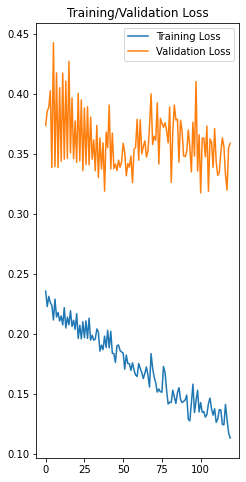

[array([[73.2558]], dtype=float32), array([[146.87737]], dtype=float32), array([[184.06592]], dtype=float32), array([[266.85416]], dtype=float32), array([[441.77383]], dtype=float32), array([[475.77817]], dtype=float32), array([[533.61334]], dtype=float32), array([[128.75446]], dtype=float32), array([[42.49402]], dtype=float32), array([[220.45021]], dtype=float32), array([[221.83298]], dtype=float32), array([[478.30075]], dtype=float32), array([[58.236656]], dtype=float32), array([[126.82854]], dtype=float32), array([[212.99142]], dtype=float32)]
[73.2558, 146.87737, 184.06592, 266.85416, 441.77383, 475.77817, 533.61334, 128.75446, 42.49402, 220.45021, 221.83298, 478.30075, 58.236656, 126.82854, 212.99142]


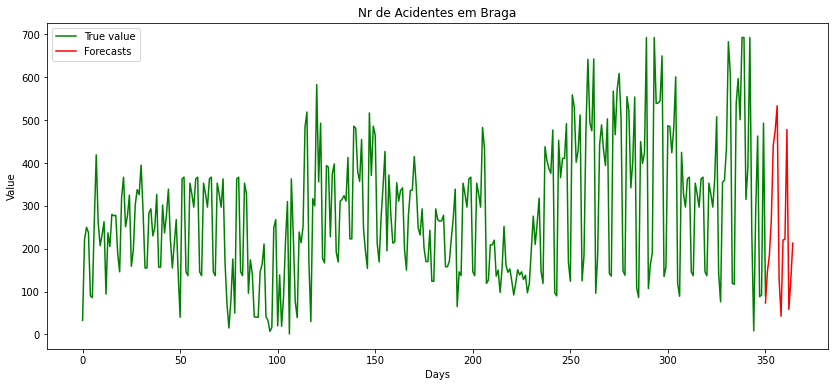

In [17]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [18]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [19]:
for f in final_dict:
  print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
  print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.2964838167031606, 0.25650629003842673, 0.2976859817902247, 0.37589935610691705, 0.3372592404484749, 0.3683675353725751] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.25110604931910835, 0.21529253045717875, 0.2527622144420942, 0.37884282489617666, 0.33786515136559797, 0.37774514695008593] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.2152706627547741, 0.18192843022445837, 0.21674798727035524, 0.41303233688076335, 0.3701092609763145, 0.41675342117746667] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.2541650522914198, 0.2209331589440505, 0.2547686666250229, 0.3811330695119169, 0.3395206444793277, 0.3799864762359195] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.22921075898188134, 0.1993388299036909, 0.22928204663373805, 0.3767593621655747, 0.3282046846769474, 0.373066120070

In [20]:
pd.DataFrame.from_dict(final_dict, orient='index',columns=['Loss', 'MAE', 'RMSE', 'VAL_LOSS', 'VAL_MAE', 'VAL_RMSE'])

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.296484,0.256506,0.297686,0.375899,0.337259,0.368368
2,0.251106,0.215293,0.252762,0.378843,0.337865,0.377745
3,0.215271,0.181928,0.216748,0.413032,0.370109,0.416753
4,0.254165,0.220933,0.254769,0.381133,0.339521,0.379986
5,0.229211,0.199339,0.229282,0.376759,0.328205,0.373066
6,0.201059,0.174402,0.201149,0.388002,0.339479,0.384385
7,0.270928,0.233424,0.268686,0.365646,0.321117,0.356561
8,0.236802,0.200885,0.234787,0.366491,0.322681,0.344790
9,0.222625,0.188392,0.221306,0.372042,0.321796,0.355866
